# Reflections on SXSW

A review of Apple's marketing and branding strategies at this year's South by Southwest Conference, to help the Apple marketing team plan next year's South by Southwest campaign.

## 0. Goals of the Analysis

To provide an overview of the brand's perception at this year's conference: what did people like, dislike and discuss the most? How was Apple perceived relative to its competitors?

- Build a classifier to "score" tweets as most negative, most positive and most neutral
- Determine the most negative and most positive SXSW tweets concerning Apple and its products
- Summarize the topics discussed in negative, neutral and positive tweets regarding Apple & its products


Ultimately, we hope to provide concrete recommendations for next year's SXSW brand & marketing strategy based on what was successful this year.

## Environment Set Up

Install xgboost and gensim, and download stopwords from nltk.

In [1]:
%pip install xgboost

%pip install gensim

%pip install pyLDAvis

%pip install wordcloud

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 17.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
ERROR: pip's dependency

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Make a list of package versions used in this environment.

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pyLDAvis
import gensim
import xgboost
import wordcloud
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

Matplotlib is building the font cache; this may take a moment.


nltk==3.8.1
sklearn==1.2.2
pandas==2.0.1
numpy==1.25.0
seaborn==0.12.2
pyLDAvis==3.4.0
gensim==4.3.1
xgboost==1.7.6
wordcloud==1.9.2


Set a seed for random state.

In [3]:
seed = 8945593

Import specific packages needed from various libraries.

In [4]:
# general preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text-specific preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# analysis
from nltk.probability import FreqDist
# topic modeling
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# vectorizers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# grid search
from sklearn.model_selection import GridSearchCV

## 1. Data Understanding
### 1.1 Part 1

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

The data was downloaded from the above link on April 21, 2023 and has been stored in .csv format in the below referenced S3 bucket.

In [5]:
# load data

read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The "emotion_in_tweet_is_directed_at" category indicates the specific product at which the sentiment in the tweet is directed, if possible. For ease of analysis, we will add a column titled "brand" which simply indicates whether the object of the sentiment is "Apple", "Google", "Android" (or None), so that we can explore the distribution of tweet sentiment by brand.

We'll also rename the columns so that actions require less typing.

In [6]:
# change column names for ease of use
data.rename({'emotion_in_tweet_is_directed_at': 'object',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

# add column (brand)
apple_categories = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
                    'Other Apple product or service']

android_categories = ['Android App', 'Android']

google_categories = ['Google', 'Other Google product or service']

brand_names = dict(zip(apple_categories, ['Apple']*len(apple_categories)))
brand_names.update(dict(zip(android_categories, ['Android']*len(android_categories))))
brand_names.update(dict(zip(google_categories, ['Google']*len(google_categories))))

data['brand'] = data.object.replace(brand_names)

data.head()

,tweet_text,object,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


#### Summary

- How many tweets are in the dataset overall?

&nbsp;

<center><b>9093 tweets</b></center>

- What is the distribution of the sentiment category?

| Sentiment | % of Data |
| --- | --- |
| Neutral | 59% |
| Positive | 33% |
| Negative | 6% |
| Null | 2% |

- How many null values are we dealing with for the object of the sentiment?

<center><b>357 tweets</b> are labeled as having a positive or negative emotion, but do not indicate the object of the sentiment in the tweet.</center>

&nbsp;

- Out of tweets for which the object of the sentiment is labeled, how many have sentiment directed toward ...

    - Apple? &nbsp;&nbsp; **2337 positive and negative tweets**
    - Google? &nbsp;&nbsp; **697 positive and negative tweets**
    - Android? &nbsp;&nbsp; **157 positive and negative tweets**
    
&nbsp;

- What is the distribution of sentiment for each brand?

<center><u>Apple and Google</u></center>
<center>~17% negative and ~83% positive</center>

&nbsp;

<center><u>Android</u></center>
<center>~10% negative and ~90% positive</center>

- What is the average length of a tweet in this dataset (in words)?

<center>The mean length of a tweet in this dataset is <b>18 words</b>. The shortest tweet contains only 2 words; the longest tweet contains 33 words.</center>

**Visualizations**

Below, graphs are generated to show the count of positive and negative tweets directed toward each brand.

Tweets with "no emotion" or ambiguous emotion ("I can't tell") are not included as most neutral tweets do not specify a brand.

In [7]:
sentiment_counts_by_brand = data.loc[~data.object.isna()].groupby(['brand', 'sentiment'])['tweet_text'].count()

Set style of plots to use throughout notebook.

*Note: The style is meant to emulate the color palette of the first graphic on the home page of the Apple website, as of June 7, 2023, which is introducing the Apple Vision Pro.*

In [7]:
plt.style.use("dark_background")
sns.set_palette('hsv')

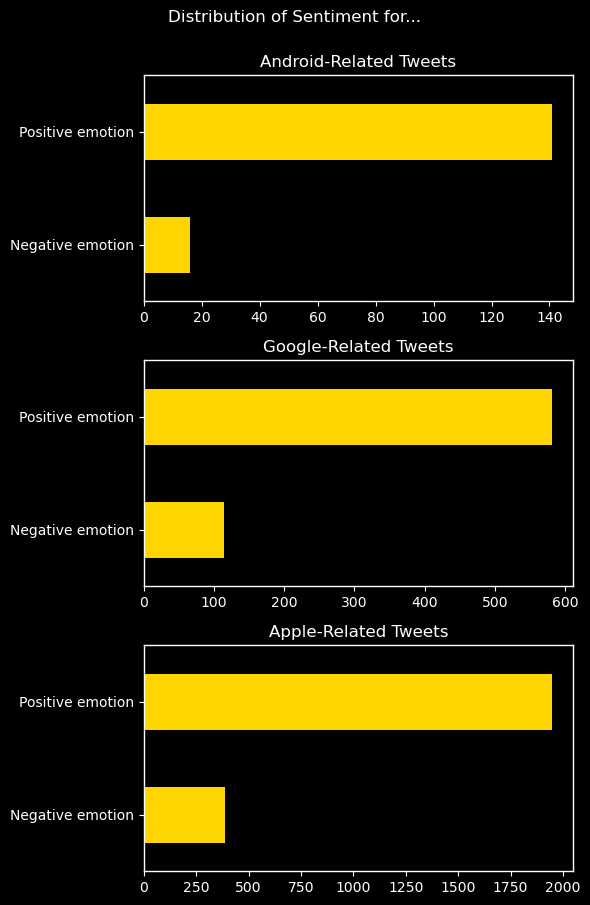

In [164]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 9))

# Android plot
sentiment_counts_by_brand.loc[('Android',)].drop(
    ['No emotion toward brand or product'], axis=0
).plot(kind='barh', ax=ax[0])
ax[0].set_title('Android-Related Tweets')

# Google plot
sentiment_counts_by_brand.loc[('Google',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[1])
ax[1].set_title('Google-Related Tweets')

# Apple plot
sentiment_counts_by_brand.loc[('Apple',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[2])
ax[2].set_title('Apple-Related Tweets')

# don't label y-axis
for axis in ax:
    axis.set_ylabel('')
    
# avoid overlap of subplots
fig.suptitle('Distribution of Sentiment for...', y=1)
fig.tight_layout();

In [173]:
!git log --oneline

6642ec2 (HEAD -> main, origin/main, origin/HEAD) set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 2. Data Preparation
### 2.1 Part 1

Deal with null values.

In [8]:
# deal with null values
data.loc[data.tweet_text==None]

,tweet_text,object,sentiment,brand


In [9]:
data.dropna(subset=['tweet_text'], axis=0, inplace=True)

Split the data into train, validation and test sets.

In [10]:
X = data['tweet_text'].copy()
y = data['sentiment'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.25)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5454,)
(1819,)
(1819,)


Label encode the target.

In [11]:
# label encoding
le = LabelEncoder()

y_train_encoded = pd.Series(le.fit_transform(y_train), index=y_train.index)

y_val_encoded = pd.Series(le.transform(y_val), index=y_val.index)
y_test_encoded = pd.Series(le.transform(y_test), index=y_test.index)

Remove stop words, strip punctuation, and stem or lemmatize tokens.

In [12]:
# remove stop words, strip punctuation, and stem or lemmatize tokens
stopwords_list = stopwords.words('english')
stopwords_list.extend(['rt', 'sxsw', 'mention', 'quot;s&quot', 'quot;x&quot', 'quot;w&quot', 'link', 'sxswi', "i'm"])

porter = PorterStemmer()

X_train_stemmed = X_train.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

X_train_stemmed.head()

5711    [fals, alarm, googl, circl, come, probabl, eve...
8483    [notic, ds, come, weekend, mani, iphon, ser, h...
7760    [said, abl, ge, ipad, 2, appl, pene, pop-up, s...
6315          [migh, need, g, appl, day, hink, key, worn]
3258                 [get, readi, listen, parti, podcast]
Name: tweet_text, dtype: object

In [13]:
X_val_stemmed = X_val.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

X_test_stemmed = X_test.map(lambda x: [porter.stem(
    w.lower().strip(string.punctuation).strip('quot;').strip('&quot')
) for w in x.split() if w.lower().strip(string.punctuation) not in stopwords_list])

For ease of use when modeling, map the list of stems to a string of stems.

In [14]:
X_train_strings = X_train_stemmed.map(lambda x: ' '.join(x))
X_train_strings.head()

5711    fals alarm googl circl come probabl ever  much...
8483    notic ds come weekend mani iphon ser hour late...
7760     said abl ge ipad 2 appl pene pop-up store austin
6315                   migh need g appl day hink key worn
3258                       get readi listen parti podcast
Name: tweet_text, dtype: object

In [15]:
X_val_strings = X_val_stemmed.map(lambda x: ' '.join(x))
X_test_strings = X_test_stemmed.map(lambda x: ' '.join(x))

## 1. Data Understanding
### 1.2 Part 2

Now that we have tokenized each tweet, we can build a frequency distribution for each sentiment category, for each brand. (It's possible that doing so will reveal additional stop words that ought to be removed, or some other pattern that can be captured in the data.)

To analyze the word distribution for each value of the target, we need a set of all training data with the labels included.

In [16]:
all_train = pd.concat([X_train_stemmed.map(lambda x: ' '.join(x)), y_train], axis=1)
all_train.head()

,tweet_text,sentiment
5711,fals alarm googl circl come probabl ever much...,Negative emotion
8483,notic ds come weekend mani iphon ser hour late...,Negative emotion
7760,said abl ge ipad 2 appl pene pop-up store austin,No emotion toward brand or product
6315,migh need g appl day hink key worn,No emotion toward brand or product
3258,get readi listen parti podcast,No emotion toward brand or product


Write a function to build a frequency distribution of the most common *n* words and display the results as a bar graph.

In [27]:
def display_fdist(data, n, normalize=False):
    '''Displays a bar graph representing the top n words in the data.'''
    fdist = FreqDist(' '.join(data.tolist()).split())
    top_n = {x[0]: x[1] for x in fdist.most_common(n)}
    raw = pd.Series(top_n)
    normalized = pd.Series(dict(zip(top_n.keys(), [x/fdist.N() for x in top_n.values()])))
    
    if normalize:
        graph_data = normalized
    else:
        graph_data = raw
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    sns.barplot(x=graph_data.values, y=graph_data.index);

Examine the most frequently occurring stems across the entire training data.

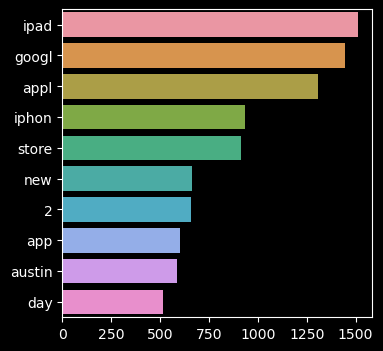

In [28]:
display_fdist(all_train.tweet_text, 10)

Normalizing the frequency distribution above suggests that, for modeling purposes, excluding words which occur more than 1% of the time would eliminate the top 10 words, and excluding words which occur more than 5% of the time would not eliminate any of the vocabulary.

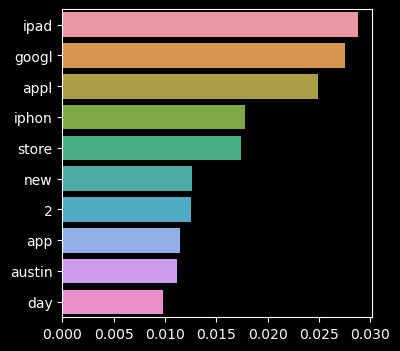

In [29]:
display_fdist(all_train.tweet_text, 10, normalize=True)

Examine the top 20 words in the frequency distribution for negative tweets.

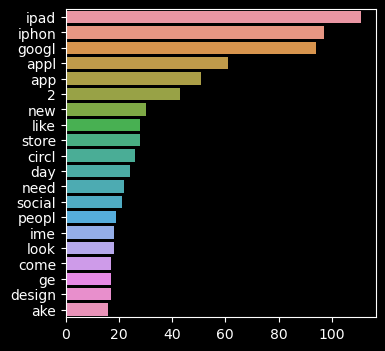

In [30]:
display_fdist(all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'], 20)

Examine the top 20 words in the frequency distribution for positive tweets.

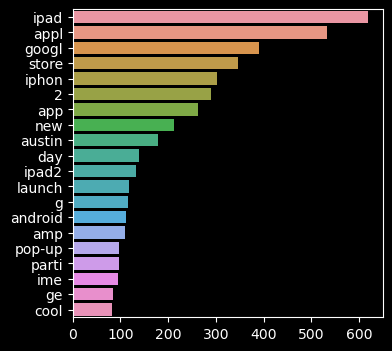

In [31]:
display_fdist(all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'], 20)

Build a frequency distribution that includes bigrams (and possible trigrams.)

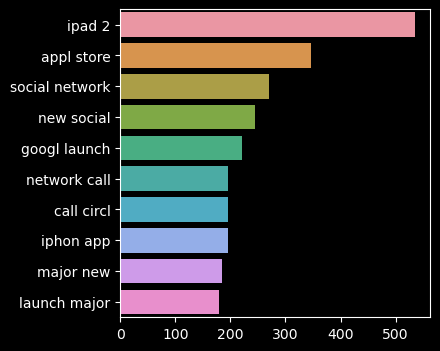

In [32]:
# build a frequency distribution that includes bigrams and possibly trigrams
top10 = FreqDist(nltk.bigrams(' '.join(all_train.tweet_text.tolist()).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

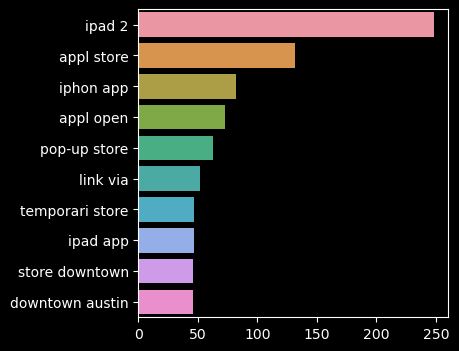

In [123]:
# build a frequency distribution for bigrams in POSITIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

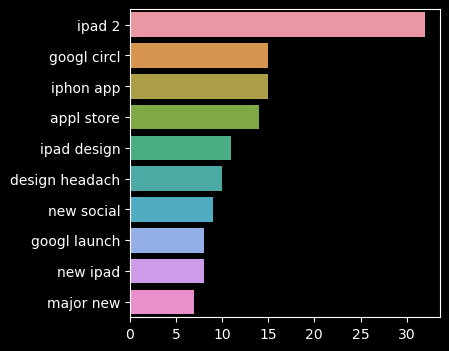

In [33]:
# build a frequency distribution for bigrams in NEGATIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index);

In [130]:
!git log --oneline

2e021cf (HEAD -> main, origin/main, origin/HEAD) Clean text data and build frequency distributions
6642ec2 set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 1. Data Understanding
### 1.3 Topic Modeling

Create a corpus and dictionary for each "set" of tweets (positive, negative, neutral and Apple-specific.)

Write a function to optimize the number of topics (based on coherence score) for a given corpus and dictionary. Have the function print the best coherence score and return the best model.

Visualize topics with pyLDAvis.

Order topics by score (of semantic similarity) and examine the top 5, including the "most representative tweet" for each topic.

Get a set of all positive, negative and neutral tweets in the training data. Additionally, find all tweets directed toward Apple in the training dataset.

In [17]:
all_train = pd.concat([X_train_stemmed, y_train], axis=1)

negative_tweets = all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].copy()
positive_tweets = all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].copy()
neutral_tweets = all_train.loc[all_train.sentiment=='No emotion toward brand or product', 'tweet_text'].copy()

apple_index = data.loc[X_train.index].loc[data.brand=='Apple', 'tweet_text'].index
apple_tweets = X_train_stemmed.loc[apple_index]

Next, generate a corpus and dictionary for each set.

In [18]:
def get_corpus_and_dict(documents):
    '''Given a set of tweets (documents), returns the corpus, dictionary and texts required to train gensim's LDA
    model.'''
    # generate bigrams
    bigrams = gensim.models.Phrases(documents.to_list()) # use default min count & threshold
    bigram_model = gensim.models.phrases.Phraser(bigrams)

    def make_bigrams(texts):
        return [bigram_model[doc] for doc in texts]

    texts = make_bigrams(documents.to_list())

    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word, texts

Select the best fitting LDA model based on the model's coherence score.

In [19]:
def select_best_lda(dictionary, corpus, texts, start=2, stop=20):
    '''Use the coherence values for LDA models with start to stop number of topics, by 2s, to determine and return
    the best LDA model for this dictionary and corpus with these texts.'''
    coherence_values = []
    model_candidates = []
    for num_topics in range(start, stop + 2, 2):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                                    random_state=seed, chunksize=500, passes=10, alpha='auto')
        model_candidates.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    print(f'Coherence score for best model: {max(coherence_values)}')
    
    return model_candidates[np.argmax(coherence_values)]

Write an overarching function to summarize a set of tweets using topic modeling. (The above two functions are helper functions for the `topic_model_summary` function below.)

A couple of other helper functions are needed first.

The topic_index function is a helper function for the `most_interpretable_topics` function, which enables us to find the integer representations of the most interpretable topics (by coherence score) generated by an LDA model.

In [20]:
def topic_index(best_lda_model):
    '''Returns an "index" of topics described by word distributions.'''

    index_of_topic_reps = []

    for topic_rep in [topic_rep for index, topic_rep in best_lda_model.print_topics(num_words=8)]:
        pieces = [item\
                  for sublist in [phrase.split('+') for phrase in topic_rep.split('*')]\
                  for item in sublist]
        clean_pieces = [x.strip('\"').strip().strip('\"') for x in pieces]

        percentages = [float(piece) for piece in clean_pieces if clean_pieces.index(piece) % 2 == 0]
        words = [piece for piece in clean_pieces if clean_pieces.index(piece) % 2 == 1]

        clean_topic_rep = [(percent, word) for percent, word in zip(percentages, words)]

        index_of_topic_reps.append(clean_topic_rep)
        
    return index_of_topic_reps

In [24]:
def most_interpretable_topics(best_lda_model, texts, id2word, n=5):
    '''Returns the integer representation of the top n most coherent topics generated by an LDA model.'''
    index_of_topic_reps = topic_index(best_lda_model)

    top_n_topics = []

    for top_topic in best_lda_model.top_topics(texts=texts, dictionary=id2word, coherence='c_v', topn=8)[:n]:
        to_match = [(round(float(percent), 3), word) for percent, word in top_topic[0]]
        top_n_topics.append(index_of_topic_reps.index(to_match))

    return top_n_topics

Now we can write our overarching function to summarize a set of tweets using topic modeling.

In [27]:
def topic_model_summary(tweets):
    '''Given a series of tweets, returns a wordcloud and the most representative tweet
    for each of the top 5 most "coherent" topics produced by the best LDA topic model
    found.
    
    Returns:
    wc - wordcloud object
    lda - best lda model
    summary_tweets - most representative tweet for each topic'''
    
    global X_train
    
    corpus, id2word, texts = get_corpus_and_dict(tweets)

    best_lda_model = select_best_lda(id2word, corpus, texts)
    
    if best_lda_model.num_topics < 5:
        num_topics = best_lda_model.num_topics
    else:
        num_topics = 5
    
    top_topics = most_interpretable_topics(best_lda_model, texts, id2word, n=num_topics)
    
    # get the "most representative" tweet for each topic
    most_representative_tweets = []
    document_topics = [best_lda_model.get_document_topics(tweet) for tweet in corpus]

    for topic in top_topics:
        contribution_to_topic = []

        for doc in document_topics:
            if topic in [topic for topic, percentage in doc]:
                location = [topic for topic, percentage in doc].index(topic)
                contribution_to_topic.append(doc[location][1])
            else:
                contribution_to_topic.append(0)
        most_representative_tweets.append(np.argmax(contribution_to_topic))
        
    summary_tweets = [X_train.loc[tweets.index[i]] for i in most_representative_tweets]

    # build a word cloud for each of the top topics
    word_clouds = []
    
    for topic_index, tweet in zip(top_topics, summary_tweets):
    
        wordcloud_text = []

        for w, f in best_lda_model.show_topic(topic_index):
            wordcloud_text.extend([w]*int(100*f))
            
        wc = WordCloud(relative_scaling=1, collocations=False).generate(' '.join(wordcloud_text))
        word_clouds.append(wc)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show();
        
        print(tweet)
        
    return word_clouds, best_lda_model, summary_tweets

Coherence score for best model: 0.4576159282791464


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


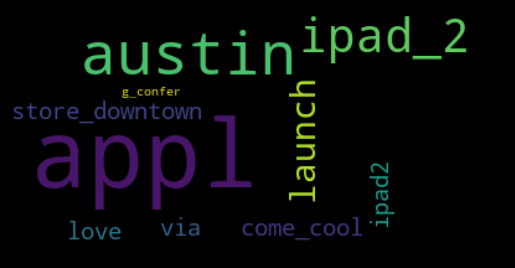

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Love the Apple pop-up store at #SXSW. So freaking smart. Now, one question. Will AT&amp;T bring trucks for signal again? Please say yes.


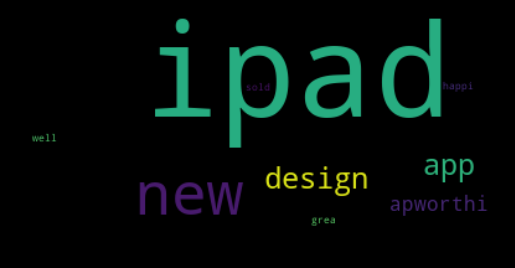

Vinh: Flipboard is a step forward for iPad mags, those that get it right will go down this path - not the Wired path #sxsw


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


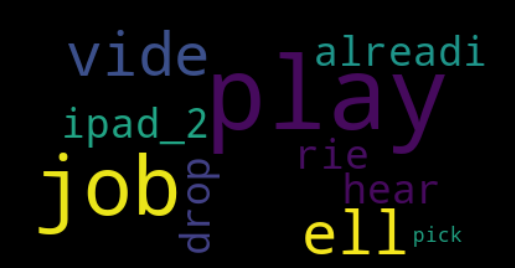

Can already tell i should have brought as ass pillow and iPhone backup charger to #sxsw #numbassonfloor


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


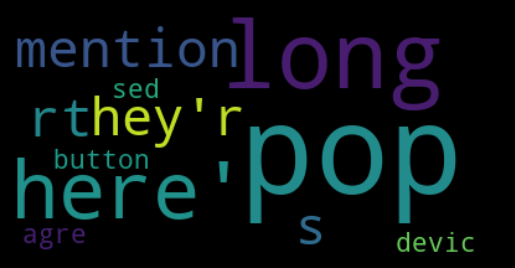

Wow. Shakespeare's Pub on 6th St. Here's to the delete button on the iPhone video camera. #SXSW


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


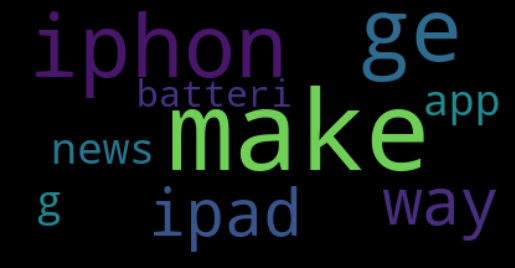

I'm headed down to #SXSW to hear a talk on integrated social network dynamics and team synergy.  I've got my iPad ready to go.


([<wordcloud.wordcloud.WordCloud at 0x7fe9d0673460>,
 ['Love the Apple pop-up store at #SXSW. So freaking smart. Now, one question. Will AT&amp;T bring trucks for signal again? Please say yes.',
  'Vinh: Flipboard is a step forward for iPad mags, those that get it right will go down this path - not the Wired path #sxsw',
  'Can already tell i should have brought as ass pillow and iPhone backup charger to #sxsw #numbassonfloor',
  "Wow. Shakespeare's Pub on 6th St. Here's to the delete button on the iPhone video camera. #SXSW",
  "I'm headed down to #SXSW to hear a talk on integrated social network dynamics and team synergy.  I've got my iPad ready to go."])

In [28]:
topic_model_summary(apple_tweets)

Coherence score for best model: 0.4524414642333764


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


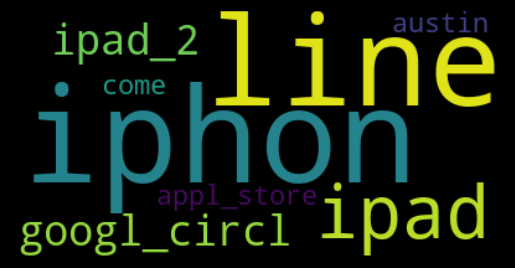

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


@mention good job @mention #sxsw! went home &amp; watched season 1 of the guild =D. sucks that your tweet abt the iphone hijack is a top tweet lol


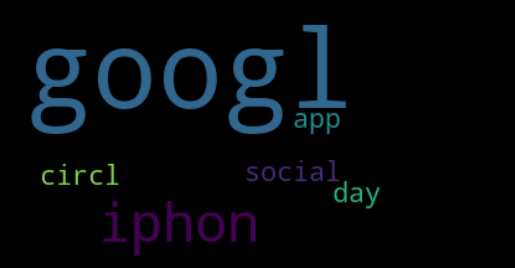

Apps distract pubs, sez Khoi Vinh. Instead of focusing on reader exp, they're delivering same content 3 ways. #SXSW  {link}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


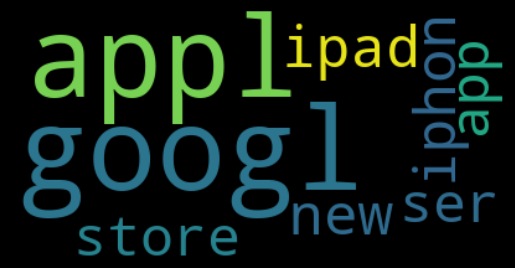

#SXSW a tougher crowd than Colin Quinn RT @mention Hey Marissa Mayer Please tell us something new Not about products Google launched months ago


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


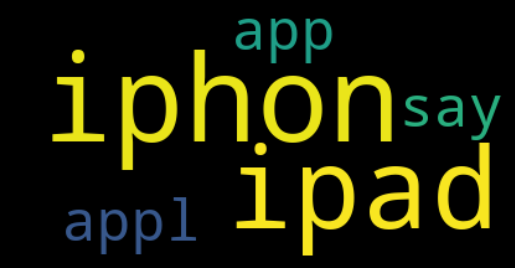

line around the corner for #iPad2 at #sxsw, i say wait on it. I've already got two cameras on my #iPhone sorry #apple


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


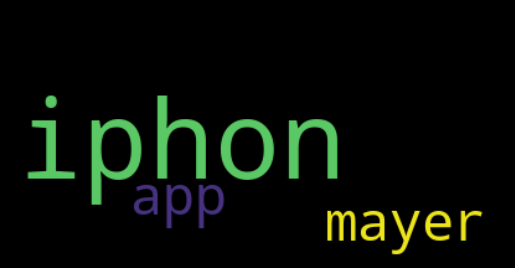

Length of Google penalty based on severity of breach of webmaster guidelines. i.e.white text on white bgr might get 30 day pen. #sxsw #qagb


([<wordcloud.wordcloud.WordCloud at 0x7fe9d0647220>,
 ['@mention good job @mention #sxsw! went home &amp; watched season 1 of the guild =D. sucks that your tweet abt the iphone hijack is a top tweet lol',
  "Apps distract pubs, sez Khoi Vinh. Instead of focusing on reader exp, they're delivering same content 3 ways. #SXSW  {link}",
  '#SXSW a tougher crowd than Colin Quinn RT @mention Hey Marissa Mayer Please tell us something new Not about products Google launched months ago',
  "line around the corner for #iPad2 at #sxsw, i say wait on it. I've already got two cameras on my #iPhone sorry #apple",
  'Length of Google penalty based on severity of breach of webmaster guidelines. i.e.white text on white bgr might get 30 day pen. #sxsw #qagb'])

In [29]:
topic_model_summary(negative_tweets)

Coherence score for best model: 0.4605837163092613


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


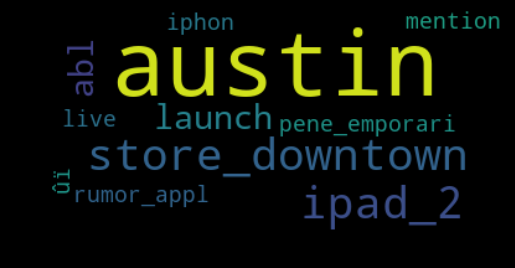

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


I'll be at the Austin Convention Center today w/ my @mention fam... showing my new iPhone game. #SXSW


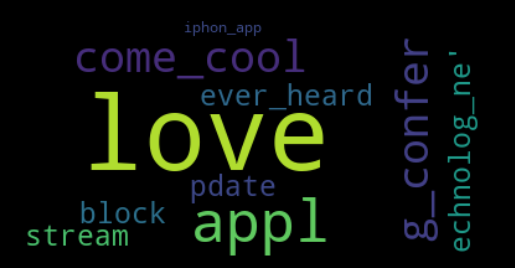

Updated NPR Music iPhone app has song info for All Songs 24/7 &amp; live video streaming just in time for #SXSW {link}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


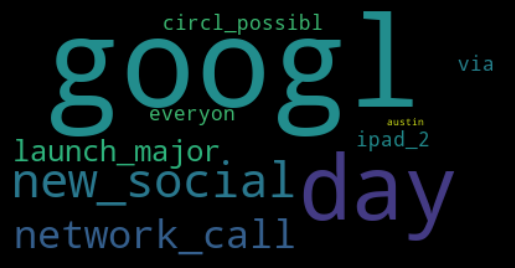

Waiting eagerly for Google to launch their secret new Social Network called Circles today at #SXSW &gt;&gt; Any new updates ?


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


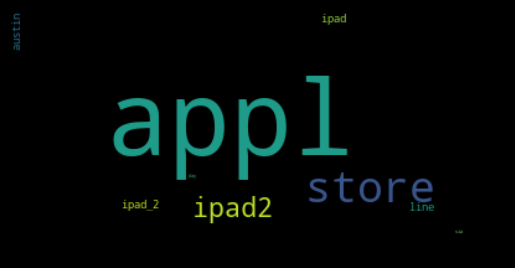

Good talk from AKQAs @mention on iPad interface w/ callback to design principles. My wish: go beyond media/marketing examples. #fb #SxSW


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


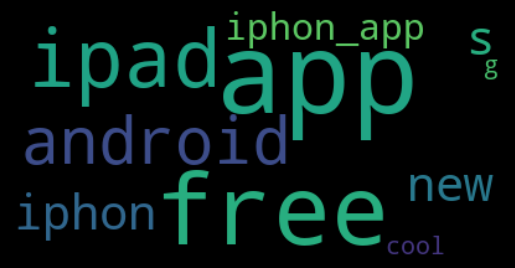

RT @mention RT @mention Just talked to Mike Tyson #SXSW about his new iPhone game, which lets you fight Pauly D and other celebs. {link}


([<wordcloud.wordcloud.WordCloud at 0x7fe9d075edd0>,
 ["I'll be at the Austin Convention Center today w/ my @mention fam... showing my new iPhone game. #SXSW",
  'Updated NPR Music iPhone app has song info for All Songs 24/7 &amp; live video streaming just in time for #SXSW {link}',
  'Waiting eagerly for Google to launch their secret new Social Network called Circles today at #SXSW &gt;&gt; Any new updates ?',
  'Good talk from AKQAs @mention on iPad interface w/ callback to design principles. My wish: go beyond media/marketing examples. #fb #SxSW',
  'RT @mention RT @mention Just talked to Mike Tyson #SXSW about his new iPhone game, which lets you fight Pauly D and other celebs. {link}'])

In [30]:
topic_model_summary(positive_tweets)

Coherence score for best model: 0.49062957143504293


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


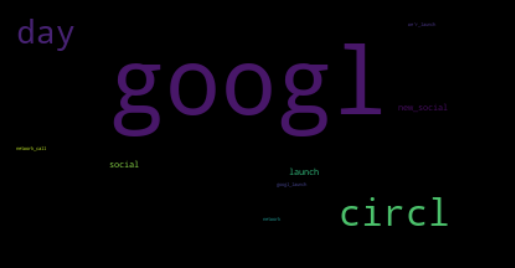

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


RT @mention Public notes for &quot;5 steps to bulletproof UX strategy&quot;: {link} #sxsw #rhjr_ux5


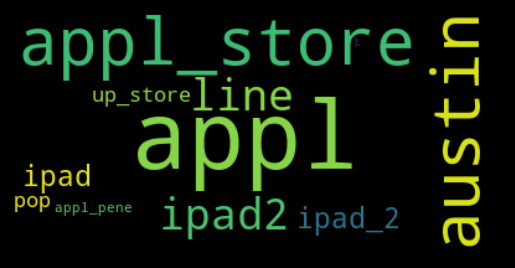

Line at pop up Apple store in Austin. First person was here at 6 a.m.they have to wait until 5 p.m. #SXSW #ipad2  {link}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


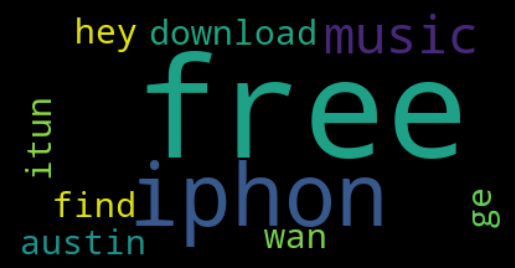

RT #LOVE&lt;=&gt; Hey Austin, know a little about #iPhone or #Android, love music &amp; wanna make $20/hour during #SXSW? Please let me know.: Hey...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


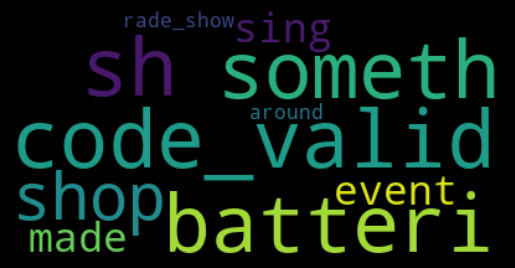

RT @mention Tweet this to register for exclusive passes to events, parties + iPad 2 during #SXSW - &quot;Give me liberty and/or a free #sxswpass - please RT&quot;


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


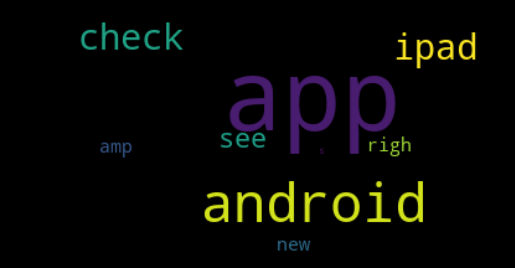

Art From the #iPad on view daily for #sxsw + free coffee, iDevice recharging at @mention åÇ Austin Details {link}


([<wordcloud.wordcloud.WordCloud at 0x7fe9cf450070>,
 ['RT @mention Public notes for &quot;5 steps to bulletproof UX strategy&quot;: {link} #sxsw #rhjr_ux5',
  'Line at pop up Apple store in Austin. First person was here at 6 a.m.they have to wait until 5 p.m. #SXSW #ipad2  {link}',
  'RT #LOVE&lt;=&gt; Hey Austin, know a little about #iPhone or #Android, love music &amp; wanna make $20/hour during #SXSW? Please let me know.: Hey...',
  'RT @mention Tweet this to register for exclusive passes to events, parties + iPad 2 during #SXSW - &quot;Give me liberty and/or a free #sxswpass - please RT&quot;',
  'Art From the #iPad on view daily for #sxsw + free coffee, iDevice recharging at @mention åÇ Austin Details {link}'])

In [31]:
topic_model_summary(neutral_tweets)

In [235]:
!git commit -m 'Explore topic modeling with LDA (messy)'

[main 532e30a] Explore topic modeling with LDA (messy)
 Committer: EC2 Default User <ec2-user@ip-172-16-43-87.us-east-2.compute.internal>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 2605 insertions(+), 101 deletions(-)


In [241]:
!git commit -m 'Clean up topic modeling'

[main 7719a50] Clean up topic modeling
 Committer: EC2 Default User <ec2-user@ip-172-16-43-87.us-east-2.compute.internal>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 145 insertions(+), 1122 deletions(-)


In [243]:
!git log --oneline

7719a50 (HEAD -> main, origin/main, origin/HEAD) Clean up topic modeling
532e30a Explore topic modeling with LDA (messy)
2e021cf Clean text data and build frequency distributions
6642ec2 set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 3. Modeling
### 3.1 Selecting a Vectorizer and Optimizing Hyperparameters for Each Classification Algorithm

Use pipelines to test different vectorization techniques with different classification algorithms.

<u>Vectorizers</u>
- Count vectorization: ngram range, min / max df, max vocab
- "One hot" vectorization
- Tfidf vectorization: same as count vectorizer settings
- Mean word embeddings (using gensim's pretrained word2vec model)

<u>Classifiers</u>
- Decision Tree
- Nearest Neighbors
- Support Vector Classifier
- Naive Bayes
- Random Forest
- XGBoost (other library)

Use grid search and cross validation to find the optimal vectorization and hyperparameter settings for each classification algorithm.

In order to find the "best" preprocessing method to use for our tweet classification model, I am going to write a simple wrapper for scikit learn's count vectorizer and tfidf vectorizer to allow compatibility with scikit learn's grid search cross validation.

In [18]:
class WrappedCountVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None):
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.vectorizer = CountVectorizer(ngram_range=self.ngram_range,
                                          max_df=self.max_df,
                                          min_df=self.min_df,
                                          max_features=self.max_features)
        
    def fit(self, documents, labels=None):
        # fit scikit learn vectorizer
        self.vectorizer.fit(documents)
        
        return self
    
    def transform(self, documents):
        # transform documents using scikit learn vectorizer
        return self.vectorizer.transform(documents)
    # note: this will be a sparse matrix

In [46]:
# find the settings for count vectorization which maximize performance with "baseline" version of each classifier
classifiers = [DecisionTreeClassifier(random_state=seed),
               KNeighborsClassifier(),
               MultinomialNB(),
               SVC(random_state=seed),
               RandomForestClassifier(random_state=seed),
               XGBClassifier(random_state=seed)]
classifier_names = ['decision tree', 'nearest neighbors classifier', 'naive bayes', 'support vector machine',
                    'random forest', 'xg boost']
vectorizer = WrappedCountVectorizer()
count_classifier_scores = {'train': [], 'validate': []}
count_pipeline_settings = []

for classifier, classifier_name in zip(classifiers, classifier_names):
    
    pipe = Pipeline(steps=[
    ('vectorize', vectorizer),
    ('classify', classifier)
    ])
    
    param_grid = [
        {'vectorize__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'vectorize__min_df': [0.01, 0.05, 1], # 1 here is an int, not a float; so a word has to appear once
         'vectorize__max_df': [0.99, 0.95, 1.0], # 1.0 here is a float; so a word can appear in 100% of docs
         'vectorize__max_features': [None, 200, 500, 1000, 1500, 3000]}
    ]
    
    grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True,
                               error_score='raise')
    
    grid_search.fit(X_train_strings, y_train_encoded)
    
    count_classifier_scores['train'].append(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
    count_classifier_scores['validate'].append(grid_search.best_score_)
    count_pipeline_settings.append(grid_search.best_estimator_)
    
    print(classifier_name)
    print('----------')
    print(f'Best estimator: {grid_search.best_estimator_}')
    print(f'Mean validation accuracy: {grid_search.best_score_}')
    print(f"Mean training accuracy: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]}")
    print('\n')

decision tree
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedCountVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', DecisionTreeClassifier(random_state=8945593))])
Mean validation accuracy: 0.6136780344701137
Mean training accuracy: 0.9755225522552257


nearest neighbors classifier
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedCountVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', KNeighborsClassifier())])
Mean validation accuracy: 0.6092775944261093
Mean training accuracy: 0.696002933626696


naive bayes
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedCountVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', MultinomialNB())])
Mean validation accuracy: 0.6329299596626329
Mean training accuracy: 0.8265493215988265


support vector machine
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedCountVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', SVC(random_s

To summarize the best results of our grid search(es) in a dataframe:

In [49]:
pd.DataFrame({'classifier_names': classifier_names,
             'mean_train_score': count_classifier_scores['train'],
             'mean_test_score': count_classifier_scores['validate'],
             'settings': count_pipeline_settings})

,classifier_names,mean_train_score,mean_test_score,settings
0,decision tree,0.975523,0.613678,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."
1,nearest neighbors classifier,0.696003,0.609278,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."
2,naive bayes,0.826549,0.632930,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."
3,support vector machine,0.861845,0.656399,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."
4,random forest,0.975523,0.650898,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."
5,xg boost,0.804547,0.660066,"(WrappedCountVectorizer(max_df=0.99, min_df=0...."


A count vectorizer with a minimum document frequency of 0.01 and a maximum document frequency of 0.99 (and otherwise default settings) allows the baseline versions of each classifier to perform the best.

Repeat the above experiment with tfidf vectorization to see if this improves performance.

In [19]:
class WrappedTfidfVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None):
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(ngram_range=self.ngram_range,
                                          max_df=self.max_df,
                                          min_df=self.min_df,
                                          max_features=self.max_features)
        
    def fit(self, documents, labels=None):
        # fit scikit learn vectorizer
        self.vectorizer.fit(documents)
        
        return self
    
    def transform(self, documents):
        # transform documents using scikit learn vectorizer
        return self.vectorizer.transform(documents)
    # note: this will be a sparse matrix

In [ ]:
# find the settings for tfidf vectorization which maximize performance with "baseline" version of each classifier
classifiers = [DecisionTreeClassifier(random_state=seed),
               KNeighborsClassifier(),
               MultinomialNB(),
               SVC(random_state=seed),
               RandomForestClassifier(random_state=seed),
               XGBClassifier(random_state=seed)]
classifier_names = ['decision tree', 'nearest neighbors classifier', 'naive bayes', 'support vector machine',
                    'random forest', 'xg boost']
vectorizer = WrappedTfidfVectorizer()
tfidf_classifier_scores = {'train': [], 'validate': []}
tfidf_pipeline_settings = []

for classifier, classifier_name in zip(classifiers, classifier_names):
    
    pipe = Pipeline(steps=[
    ('vectorize', vectorizer),
    ('classify', classifier)
    ])
    
    param_grid = [
        {'vectorize__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'vectorize__min_df': [0.01, 0.05, 1], # 1 here is an int, not a float; so a word has to appear once
         'vectorize__max_df': [0.99, 0.95, 1.0], # 1.0 here is a float; so a word can appear in 100% of docs
         'vectorize__max_features': [None, 200, 500, 1000, 1500, 3000]}
    ]
    
    grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True,
                               error_score='raise')
    
    grid_search.fit(X_train_strings, y_train_encoded)
    
    tfidf_classifier_scores['train'].append(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
    tfidf_classifier_scores['validate'].append(grid_search.best_score_)
    tfidf_pipeline_settings.append(grid_search.best_estimator_)
    
    print(classifier_name)
    print('----------')
    print(f'Best estimator: {grid_search.best_estimator_}')
    print(f'Mean validation accuracy: {grid_search.best_score_}')
    print(f"Mean training accuracy: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]}")
    print('\n')

decision tree
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedTfidfVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', DecisionTreeClassifier(random_state=8945593))])
Mean validation accuracy: 0.5958929226255959
Mean training accuracy: 0.9755225522552257


nearest neighbors classifier
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedTfidfVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', KNeighborsClassifier())])
Mean validation accuracy: 0.6153281994866154
Mean training accuracy: 0.7263476347634764


naive bayes
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedTfidfVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', MultinomialNB())])
Mean validation accuracy: 0.6248624862486248
Mean training accuracy: 0.742024202420242


random forest
----------
Best estimator: Pipeline(steps=[('vectorize', WrappedTfidfVectorizer(max_df=0.99, min_df=0.01)),
                ('classify', RandomForestClassifie

To summarize the best results of our grid search(es) in a dataframe:

In [ ]:
pd.DataFrame({'classifier_names': classifier_names,
             'mean_train_score': tfidf_classifier_scores['train'],
             'mean_test_score': tfidf_classifier_scores['validate'],
             'settings': tfidf_pipeline_settings})

,classifier_names,mean_train_score,mean_test_score,settings
0,decision tree,0.975523,0.595893,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."
1,nearest neighbors classifier,0.726348,0.615328,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."
2,naive bayes,0.742024,0.624862,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."
3,support vector machine,0.892006,0.655666,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."
4,random forest,0.975523,0.645948,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."
5,xg boost,0.864411,0.649982,"(WrappedTfidfVectorizer(max_df=0.99, min_df=0...."


Count vectorization was slightly more successful (than tfidf vectorization) with all baseline models. I use count vectorization with min_df=0.01 and max_df=0.99 going forward.

Below, I set up parameter grids for the three most successful baseline models (random forest, support vector machine and xg boost) so that I can perform a grid search for "optimal" hyperparameters.

In [ ]:
rf_param_grid = [
    {'random_state': [seed]}
]

svm_param_grid = [
    {'random_state': [seed]}
]

xgboost_param_grid = [
    {'random_state'{ [seed]}}
]

In [ ]:
# top_classifiers = [RandomForestClassifier(), SVC(), XGBClassifier()]
top_classifier_names = ['random forest', 'support vector machine', 'xg boost']

vectorizer = WrappedCountVectorizer(min_df=0.01, max_df=0.99)

tuned_classifier_scores = {'train': [], 'validate': []}
tuned_classifier_settings = []

param_grids = [rf_param_grid, svm_param_grid, xgboost_param_grid]

for classifier, classifier_name, param_grid in zip(top_classifiers, top_classifier_names, param_grids):
    
    pipe = Pipeline(steps=[
        ('vectorize', vectorizer),
        ('classify', classifier)
    ])
    
#    grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True,
                                error_score='raise')
    
    grid_search.fit(X_train_strings, y_train_encoded)
    
    tuned_classifier_scores['train'].append(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
    tuned_classifier_scores['validate'].append(grid_search.best_score_)
    tuned_classifier_settings.append(grid_search.best_estimator_)
    
    print(classifier_name)
    print('----------')
    print(f'Best estimator: {grid_search.best_estimator_}')
    print(f'Mean validation accuracy: {grid_search.best_score_}')
    print(f"Mean training accuracy: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]}")
    print('\n')

View the summary results for the tuned models as a dataframe.

In [ ]:
pd.DataFrame({'top_classifier_names': classifier_names,
             'mean_train_score': tuned_classifier_scores['train'],
             'mean_test_score': tuned_classifier_scores['validate'],
             'settings': tuned_classifier_settings})

In [56]:
!git log --oneline

ffb3440 (HEAD -> main, origin/main, origin/HEAD) Grid search for best vectorization technique: count vectorization
7719a50 Clean up topic modeling
532e30a Explore topic modeling with LDA (messy)
2e021cf Clean text data and build frequency distributions
6642ec2 set up notebook environment and summarize data
687bb47 Broaden hyperparameter search with Amazon SageMaker notebook
ad863bc Refactor preprocessing code
900c8c7 Tune several model candidates
943cccf Reorganize preprocessing steps
9ff1241 More EDA
ab23639 Add eda step / brand breakdown
68b4479 Build a neural network; test different architectures
e76e83f Track negative recall score
87dbcf6 Make negative recall scorer
e00e38f Build stacked embedding
7ce8a6e Build custom word2vec model; try bag of words
f641e82 Plot confusion matrix; tune logistic regression; try random forest
4041f75 Test padding mean word vector
62aefa0 Preprocess data & set up for model tuning
0dc62d4 Ignore data
6e356bf Initial commit


## 4. Evaluation
### 4.1 Analyze Model Performance on Validation Set

In this section, the best model(s) so far are evaluated on the validation set after being trained on the training set. Insights from the model's performance on the validation set may be used to adjust preprocessing techniques and model hyperparameters.

Train the best model(s) on the training set, and analyze the performance of each model on the validation set using:

- overall accuracy (visualize: raw numbers confusion matrix)

- recall for each class (visualize: confusion matrix with normalize='true')

- both of the above for Apple-related tweets specifically (and perhaps each brand)

- grade_model_confidence function (displays bar chart with mean model accuracy as a function of model confidence in predicted class)

- use LIME to investigate most negative & positive tweets, or "most confident" mistakes (incorrect predictions for which the model was most confident)

- examine feature importances for the model

## 3. Modeling
### 3.2 Adjust Preprocessing Techniques and Model Hyperparameters

Based on evaluation of candidate models on the validation set, consider tweaking preprocessing techniques (esp. vectorization) and model hyperparameters.

## 4. Evaluation
### 4.2 Final Model Evaluation on Hold-out Test Set

In this section, the single best model is evaluated on the hold-out test set to approximate model performance on unseen data. Model analytics are used to determine whether the model is worthy for deployment.

Evaluate the best model's performance on the hold-out test set.

Analyze model mistakes, grade model confidence & find most positive and negative tweets about Apple specifically.

## 5. Modeling
### 5.1 Topic Modeling for Each Brand and Sentiment Category (using LDA)

If time permits, latent dirichlet allocation is used to perform topic modeling for each brand / sentiment category combination in the dataset.

The goal is to generate a visualization to allow the Apple marketing team to quickly understand which "topics" related to Apple and its competitors were viewed positively or negatively (or received the most attention) during South by Southwest this year.

Determine the optimal number of topics for each sentiment category for Apple:

Determine the topics and their weights via clustering:

Visualize the topics:

## 6. Evaluation
### 6.1 Evaluate Topic Models

Compute the perplexity and coherence score for the best model.

## 7. Recommendations
### 7.1 Recommendations for Apple's Next SXSW Campaign

Based on confidence scores generated by classifier:

Based on topic modeling for each brand / sentiment combination:

## 8. Conclusion

<u>Possible Next Steps</u>

-
-

<u>Further Reading</u>

A summary of the results from this analysis can be found in [this presentation]().

Learn more about South by Southwest [here](https://www.sxsw.com/).